# Residual network (https://arxiv.org/abs/1512.03385)를 구현하는 것이 과제이며,

# 실습 시간에 보여드린 tf.layers.conv2d, tf.layers.dense 등을 사용하셔서 구현하시면 됩니다.

# 데이터셋은 CIFAR-100 (https://www.cs.toronto.edu/~kriz/cifar.html)을 사용하시기 바랍니다.

# Residual block을 구현하고 해당 블럭을 연속적으로 연결하는 것을 주안점으로 볼 것이므로, network의 깊이가 깊을 필요는 없습니다. 그리고 추가적인 힌트를 드리자면 인풋 레이어의 경우, ImageNet dataset이 아닌 CIFAR-100을 사용하므로 residual network 논문과는 다르게 설정하셔야 합니다.

# 데드라인은 12일 화요일 오후 11시 59분까지 입니다.

In [4]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

In [6]:
from keras.datasets import cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

169009152/169001437 [==============================] - 1060s 6us/step


In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


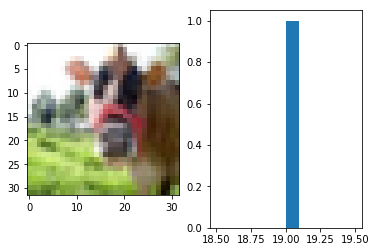

In [104]:
_, (ax1, ax2) = plt.subplots(1, 2)
sample_data = x_train[0]
sample_data0 = y_train[0]
ax1.imshow(sample_data, cmap=plt.cm.viridis);
ax2.hist(sample_data0, bins=10);

In [4]:
import tensorflow as tf

In [66]:
def model(X, by):
    X = tf.expand_dims(X, axis=4)
    with tf.variable_scope('first'):
        outs = tf.layers.conv3d(X, 128, 3, padding='same') # 필터의 갯수, 커널 사이즈 3x3
        outs = tf.nn.relu(outs)
        outs = tf.layers.max_pooling3d(outs, 2, 2)
    with tf.variable_scope('second'):
        outs = tf.layers.conv3d(X, 256, 3, padding='same') # 필터의 갯수, 커널 사이즈 3x3
        outs = tf.nn.relu(outs)
        outs = tf.layers.max_pooling3d(outs, 2, 2)
    with tf.variable_scope('third'):
        outs = tf.layers.conv3d(X, 128, 3, padding='same') # 필터의 갯수, 커널 사이즈 3x3, 보통은 줄여줌 다이아몬드 형태로
        outs = tf.nn.relu(outs)
        outs = tf.layers.max_pooling3d(outs, 2, 2)
 
    #FC 전에 flatenning
    print(outs)
    outs = tf.reshape(outs, (-1, outs.shape[1] * outs.shape[2] * outs.shape[3] * outs.shape[4]))
    outs = tf.layers.dense(outs, 256)
    outs = tf.nn.relu(outs)
    outs = tf.layers.dense(outs, 100) # cifar-100 클래스가 100개
    one_hot = tf.one_hot(by, 100)
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(
        labels = one_hot,
        logits = outs)
    loss = tf.reduce_mean(loss)
    
    
    opt = tf.train.AdamOptimizer(1e-3).minimize(loss)
    
    preds = tf.cast(tf.argmax(tf.nn.softmax(outs), axis=1),tf.int32) #가장 큰 값의 index를 가로방향으로
    acc = tf.reduce_mean(tf.cast(tf.equal(by, preds), tf.float32))
    
    return {
        'loss' : loss,
        'opt' : opt,
        'preds' : preds,
        'acc' : acc #tensor를 return
    }


In [67]:
X = tf.placeholder(tf.float32, shape=(None, 32, 32, 3))
by = tf.placeholder(tf.int32)

ours = model(X, by)

init = tf.global_variables_initializer()

ValueError: Variable first/conv3d/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-62-e6cd74231c20>", line 4, in model
    outs = tf.layers.conv3d(X, 128, 3, padding='same') # 필터의 갯수, 커널 사이즈 3x3
  File "<ipython-input-63-75c5d6dc93c6>", line 4, in <module>
    ours = model(X, by)
  File "/home/pirl/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
